# TensorFlow Tutorial 3

## Tensors

In [ ]:
import tensorflow as tf
tf.__version__

'2.12.0'

In [ ]:
# Check using CPU or GPU
print("Tensor is using GPU" if tf.config.list_physical_devices('GPU') else "Tensor is not using GPU")

Tensor is not using GPU


In [ ]:
# 2d array = matrix
x = tf.constant([[1., 2., 3.],
                 [4., 5., 6.]])
print(x)
print(x.shape)
print(x.dtype)

tf.Tensor(
[[1. 2. 3.]
 [4. 5. 6.]], shape=(2, 3), dtype=float32)
(2, 3)
<dtype: 'float32'>


In [ ]:
tf.transpose(x)

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[1., 4.],
       [2., 5.],
       [3., 6.]], dtype=float32)>

In [ ]:
# concatenate
tf.concat([x,x,x], axis = 0)  # axis = 0 -> stack over (expand the height)
tf.concat([x,x,x], axis = 1)  # axis = 1 -> put asde (expand the width)

<tf.Tensor: shape=(2, 9), dtype=float32, numpy=
array([[1., 2., 3., 1., 2., 3., 1., 2., 3.],
       [4., 5., 6., 4., 5., 6., 4., 5., 6.]], dtype=float32)>

In [ ]:
import numpy as np
a = np.array([4,5,6])
tf.convert_to_tensor(a)

<tf.Tensor: shape=(3,), dtype=int64, numpy=array([4, 5, 6])>

In [ ]:
tf.reduce_sum(a) # 4 + 5 + 6 = 15

<tf.Tensor: shape=(), dtype=int64, numpy=15>

## Variable

In [ ]:
var = tf.Variable([0.0, 0.0, 0.0]) # float32
var.assign([1,2,3]) # casting int32 -> float32

<tf.Variable 'UnreadVariable' shape=(3,) dtype=float32, numpy=array([1., 2., 3.], dtype=float32)>

In [ ]:
var.assign_add([2,2,2]) # plus operation

<tf.Variable 'UnreadVariable' shape=(3,) dtype=float32, numpy=array([3., 4., 5.], dtype=float32)>

###  Automatic differentiation

 Automatically calculate the gradient using calculus. We use this calculation to calcualate thee gradient of model's error or loss with respect to the weights $→$ optimize the weights with gradient descent

In [ ]:
x = tf.Variable(4.0)
def f(x):
  return x**2 + 2*x - 5
print(f(x))

with tf.GradientTape() as tape:
  y = f(x)
g_x = tape.gradient(y, x)  # g_x = dy/dx
g_x

tf.Tensor(19.0, shape=(), dtype=float32)


<tf.Tensor: shape=(), dtype=float32, numpy=10.0>

In [ ]:
print(4**2 + 2*4 - 5)
print(2*4 + 2) # derivative

19
10


## Graph and tf.function

- Performance optimization
- Export

In [ ]:
@tf.function
def my_func(x):
  print('Tracing.\n')
  return tf.reduce_sum(x)

In [ ]:
# first-time run -> tracing (execute python code)
x = tf.constant([4,5,6])
my_func(x)

Tracing.



<tf.Tensor: shape=(), dtype=int32, numpy=15>

In [ ]:
# on subsequent calls, TensorFlow only executes the optimized graph and skipp any non-TensorFlow steps.
x = tf.constant([4,5,6])
my_func(x)

<tf.Tensor: shape=(), dtype=int32, numpy=15>

In [ ]:
# Graph is not reusable for inputs with different signature (shape or dtype) -> new graph created -> tracing printed
x = tf.constant([7,8,9], dtype=tf.float32)
my_func(x)

Tracing.



<tf.Tensor: shape=(), dtype=float32, numpy=24.0>

## Modules, layers, and models

`tf.Module` is a class that manage 2 obvjects: `tf.Variable `and `tf.function`. Supporting 2 features:
- `tf.train.Checkpoint` $→$ save and restore the values for variables or model'state
- `tf.saved_model.save` $→$ import and export tf.Variables values and tf.function graph $→$ run model independently of Python

In [ ]:
class MyModule(tf.Module):
  def __init__(self, value):
    self.weight = tf.constant(value)

  @tf.function
  def dot(self, x):
    return tf.tensordot(x, self.weight, axes=1) # dot product

mymodule = MyModule([1,2,3])
mymodule.dot(tf.constant([3,4,5]))

<tf.Tensor: shape=(), dtype=int32, numpy=26>

In [ ]:
# [1,2,3] dot [3]
#             [4]
#             [5]
1*3 + 2*4 + 3*5

26

In [ ]:
# save the model
model_path = '/content/tf model'
tf.saved_model.save(mymodule, model_path)

In [ ]:
# The saved model is independent from the above code. We can load the model 'mymodule' from Python or other language bindings
# We can also run mymodule with tensorflow lite and tensorflow js
reloaded = tf.saved_model.load(model_path)

In [ ]:
# test the reloaded model
reloaded.dot(tf.constant([3,4,5]))

<tf.Tensor: shape=(), dtype=int32, numpy=26>

## Training loop

In [ ]:
# create exampple data
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = [9,6]

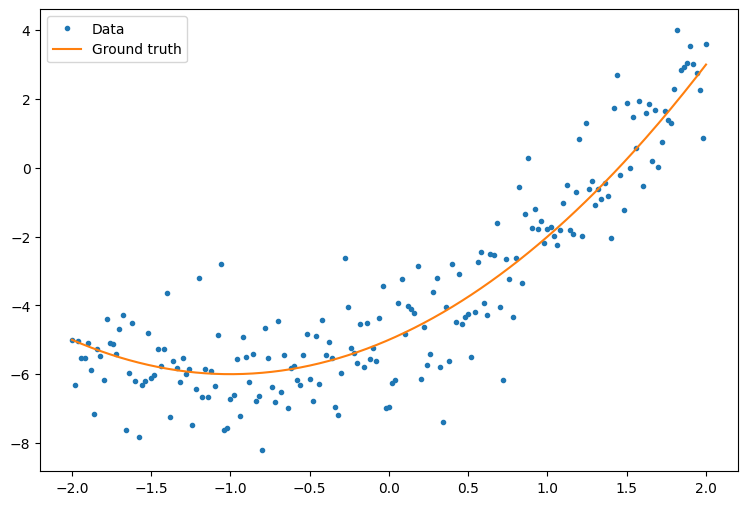

In [ ]:
x = tf.linspace(-2, 2, 201)
x = tf.cast(x, tf.float32) # casting from int32 to float32

def f(x):
  y = x**2 + 2*x - 5
  return y

y = f(x) + tf.random.normal(shape=[201]) # add some deviation / noise

plt.plot(x.numpy(), y.numpy(), '.', label='Data')
plt.plot(x, f(x), label='Ground truth')
plt.legend();

In [ ]:
class Model(tf.Module):

  def __init__(self):
    # Randomly generate weight and bias terms
    rand_init = tf.random.uniform(shape=[3], minval=0., maxval=5., seed=22)
    # Initialize model parameters
    self.w_1 = tf.Variable(rand_init[0])
    self.w_2 = tf.Variable(rand_init[1])
    self.b = tf.Variable(rand_init[2])

  @tf.function
  def __call__(self, x):
    return self.w_1 * (x**2) + self.w_2 * x + self.b

In [ ]:
# shape=[3] because there are 3 coefficients / shape=[rows,cols]
rand_init = tf.random.uniform(shape=[3,2], minval=0, maxval=5, seed=22)
rand_init

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[1.4291573 , 4.3870163 ],
       [4.6892653 , 4.8383904 ],
       [0.41632116, 1.9745845 ]], dtype=float32)>

In [ ]:
quadratic_model = Model()

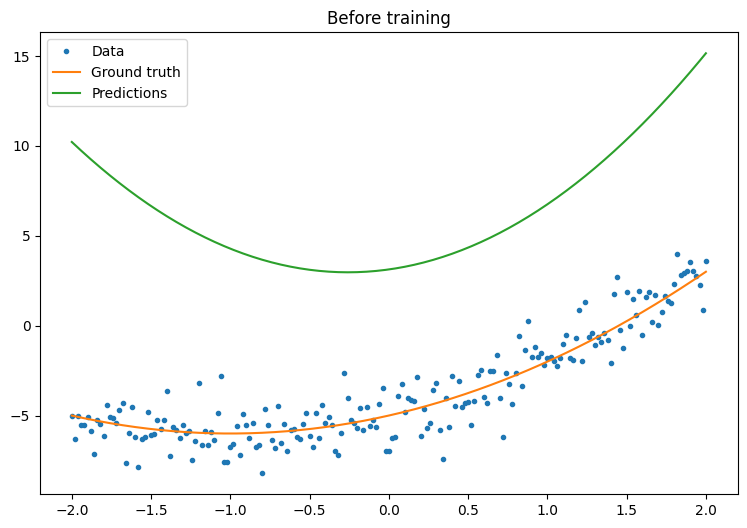

In [ ]:
def plot_preds(x, y, f, model, title):
  plt.figure()
  plt.plot(x, y, '.', label='Data')
  plt.plot(x, f(x), label='Ground truth')
  plt.plot(x, model(x), label='Predictions')
  plt.title(title)
  plt.legend()

plot_preds(x, y, f, quadratic_model, 'Before training')

- we will modify 3 parameters of our quadratic_model (2 weights and 1 bias)
- Use Mean Square Error (MSE) to update the parameters

$$L(w) = \frac{1}{N} \sum_{i=1}^N (\hat{y_i} - y_i)^2$$

$$\hat{y_i} = w_1*x^2 + w_2*x + b$$

$$L(w) = \frac{1}{N} \sum_{i=1}^N (w_1*x^2 + w_2*x + b - y_i)^2$$

- Gradient of Loss function (batch_loss) with respect to w (quadratic.Variables):

$$grads = \frac{dL}{dw} = $$

$$w_{new} = w_{old} - \frac{dL}{dw} * η$$

- The loop will calculate the gradients of loss function $L$ with respect to its input (y_pred, y) to iteratively update the parameters.
- We will use mini-batches for training $→$ memory efficiency and faster covergence.
- Batching and shuffling, we have learned about this in the tutorial 2

```
shuffle(
    buffer_size, seed=None, reshuffle_each_iteration=None, name=None
)
```


```
batch(
    batch_size,
    drop_remainder=False,
    num_parallel_calls=None,
    deterministic=None,
    name=None
)
```



In [ ]:
def L(y_pred, y):
  return tf.reduce_mean(tf.square(y_pred - y))

In [ ]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices((x, y)).shuffle(buffer_size=x.shape[0]).batch(batch_size)

Mean squared error for step 0: 44.725
Mean squared error for step 10: 6.637
Mean squared error for step 20: 3.092
Mean squared error for step 30: 1.829
Mean squared error for step 40: 1.400
Mean squared error for step 50: 1.257
Mean squared error for step 60: 1.201
Mean squared error for step 70: 1.181
Mean squared error for step 80: 1.174
Mean squared error for step 90: 1.171




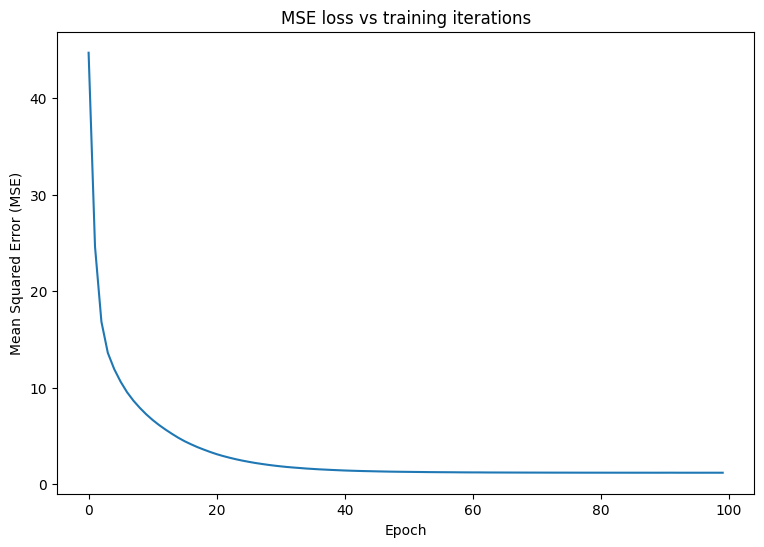

In [ ]:
# Set training parameters
epochs = 100
learning_rate = 0.01
losses = []

# Format training loop
for epoch in range(epochs):
  for x_batch, y_batch in dataset:

    # Automatic differentiation
    with tf.GradientTape() as tape:
      batch_loss = L(quadratic_model(x_batch), y_batch)

    # Update parameters with respect to the gradient calculations
    grads = tape.gradient(batch_loss, quadratic_model.variables)
    for g,w in zip(grads, quadratic_model.variables):
        w.assign_sub(learning_rate*g)

  # Keep track of model loss per epoch
  loss = L(quadratic_model(x), y)
  losses.append(loss)
  if epoch % 10 == 0:
    print(f'Mean squared error for step {epoch}: {loss.numpy():0.3f}')

# Plot model results
print("\n")
plt.plot(range(epochs), losses)
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error (MSE)")
plt.title('MSE loss vs training iterations');

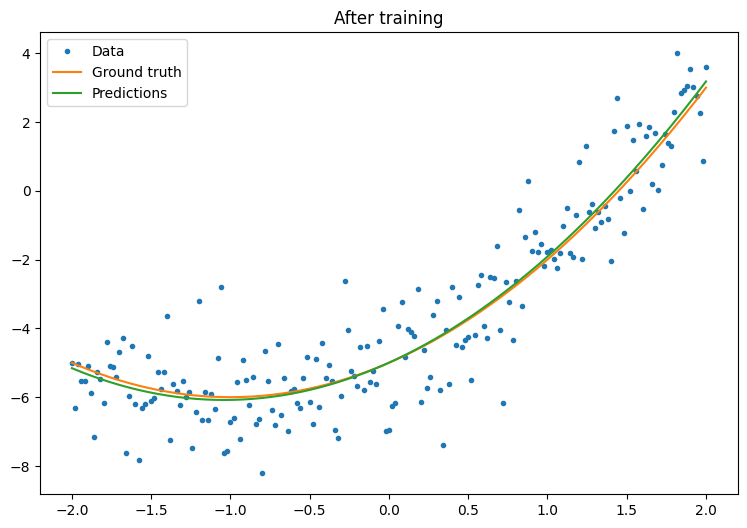

In [ ]:
plot_preds(x, y, f, quadratic_model, 'After training')

## Sequential Model

In [ ]:
new_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x : tf.stack([x, x**2], axis=1)),
    tf.keras.layers.Dense(units=1, kernel_initializer=tf.random.normal)
])

In [ ]:
new_model.compile(
    loss = tf.keras.losses.MSE,
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01) # Stochastic Gradient Descent
)

In [ ]:
history = new_model.fit(
    x,
    y,
    epochs=100,
    batch_size=32,
    verbose=0
)

Text(0.5, 1.0, 'Loss MSE through epoch with keras Sequential training progress')

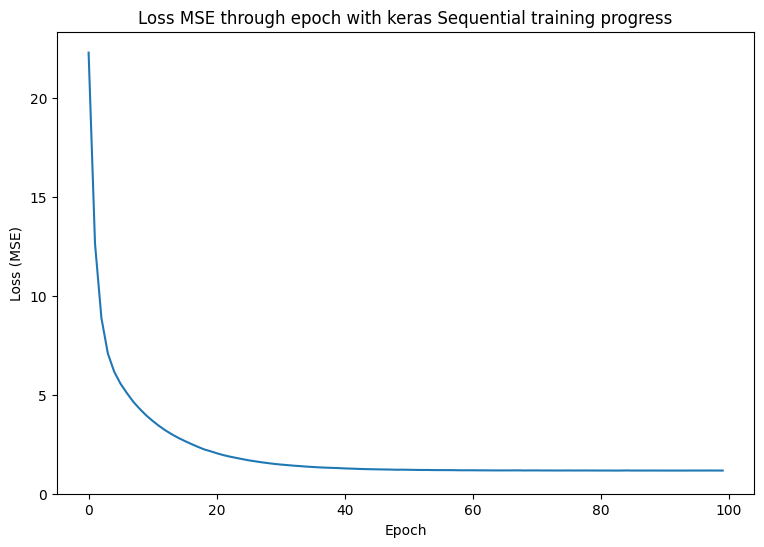

In [ ]:
# visualize
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylim([0, max(plt.ylim())])
plt.ylabel('Loss (MSE)')
plt.title('Loss MSE through epoch with keras Sequential training progress')

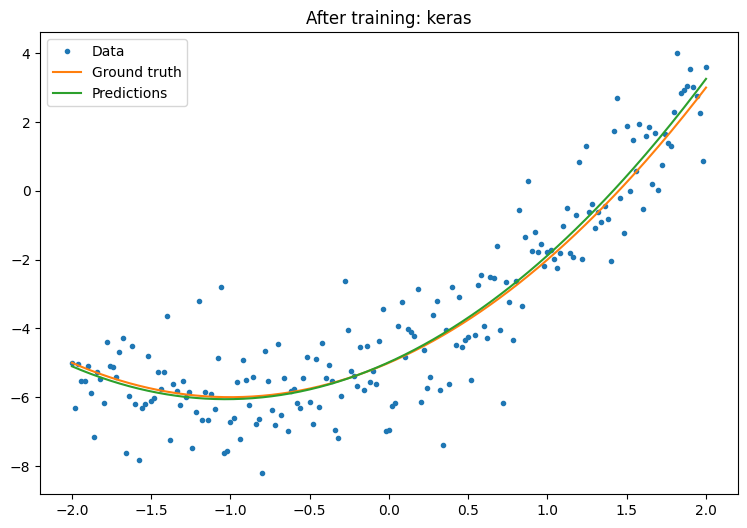

In [48]:
plot_preds(x, y, f, new_model, 'After training: keras')